In [92]:
#import sys
#!{sys.executable} -m pip install tensorflow
#!{sys.executable} -m pip install scikit-learn
#!{sys.executable} -m pip install opencv-python
#!{sys.executable} -m pip install albumentations

Importing Required Libraries

In [93]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
import numpy as np
from sklearn.model_selection import train_test_split
import os
import cv2
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import albumentations as A
from albumentations import (
    Compose, RandomRotate90, VerticalFlip, Transpose,
    OneOf, GaussNoise, RandomBrightnessContrast,ToGray
)
import numpy as np
from sklearn.utils import resample
from PIL import Image
from tqdm import tqdm
import shutil


Importing Data from 'Train' folder 

In [94]:

def importData(data_dir):
    # Importing data from the 'Train' Folder
    data = data_dir
    # Creating empty list to store filenames
    files = []
    # Iterating through the data and storing the filenames in the files list
    for _, _, files in os.walk(data):
        break
    # Printing the total number of images currently being used to train and test the models below
    print(f'Total number of files: {len(files)}')
    return files

In [95]:
files = importData(data_dir='Train')

Total number of files: 971


In [96]:
#Bootstrap function : Perform bootstrapping on a list of images and return the new bootstrap list

def load_and_preprocess_image(image_path, target_size=(256, 256)):
    """Load and preprocess a single image."""
    try:
        if isinstance(image_path, list):
            image_path = image_path[0]
        
        img = cv2.imread(str(image_path))
        if img is None:
            raise ValueError(f"Failed to load image: {image_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size)
        return img
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

def bootstrap(imageList, n_samples):
    result = [np.random.choice(imageList) for _ in range(n_samples)]
    return result

def save_augmented_images(augmented_images, original_paths, output_dir):
    """Save augmented images to a new directory."""
    # Create output directory if it doesn't exist
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs('train2')
    print(f"\nSaving augmented images to {output_dir}...")

    # Create list of paths repeated 3 times for the augmented versions
    repeated_paths = []
    for path in original_paths:
        repeated_paths.extend([path] * 3)
    
    for idx, (img, orig_path) in enumerate(zip(augmented_images, repeated_paths)):
        try:
            # Get original filename and label
            orig_filename = os.path.basename(orig_path)
            label = orig_filename.split('.')[0]
            
            # Create new filename
            aug_type = idx % 3  # 0 for original, 1 and 2 for augmented versions
            new_filename = f"aug{aug_type}_{idx}_{label}.jpg"
            save_path = os.path.join(output_dir, new_filename)
            
            # Convert from RGB to BGR for saving with cv2
            img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            
            # Save image
            cv2.imwrite(save_path, img_bgr)
            
        except Exception as e:
            print(f"Error saving augmented image {idx}: {e}")
            continue

def bootstrap_and_augment(image_list, n_samples, data_dir='Train'):
    
    # Perform bootstrapping
    print("Performing bootstrapping...")
    full_paths = [os.path.join(data_dir, img) for img in image_list]
    bootstrapped_paths = np.random.choice(full_paths, size=n_samples, replace=True)

    # 3. Define transforms
    transforms = Compose([
        RandomRotate90(p=0.2),
        VerticalFlip(p=0.2),
        ToGray(p=0.2)
    ])

    # 4. Augment
    print("Loading and augmenting images...")
    augmented_images = []
    augmented_labels = []

    for img_path in tqdm(bootstrapped_paths):
        try:
            # Get label from filename
            img_filename = os.path.basename(img_path)
            label = img_filename.split('.')[0]

            # Load and preprocess image
            img = load_and_preprocess_image(img_path)
            
            # Add original image
            augmented_images.append(img)
            augmented_labels.append(label)
            
            # Create 2 augmented versions
            for _ in range(2):
                augmented = transforms(image=img)['image']
                augmented_images.append(augmented)
                augmented_labels.append('aug_'+label)
                
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue
    
    augmented_images = np.array(augmented_images)
    augmented_labels = np.array(augmented_labels)

    # Print summary
    print("\nSummary:")
    print(f"Original bootstrap samples: {n_samples}")
    print(f"Total augmented images: {len(augmented_images)}")
    print(f"Augmented image shape: {augmented_images.shape}")

    # Save augmented images
    save_augmented_images(augmented_images, bootstrapped_paths, 'Train2')

    return augmented_images, augmented_labels

In [97]:
# Deleting Train2 folder if exist
if os.path.exists('Train2'):
    shutil.rmtree('Train2')
# Perform bootstrapping and augmentation
X_augmented, y_augmented = bootstrap_and_augment(
    image_list=files,
    data_dir='Train',
    n_samples=1200
)

files_augmented = importData(data_dir='Train2')

print("\nfiles:", files[:5])
print("\nfiles_augmented:", files_augmented[:5])

Performing bootstrapping...
Loading and augmenting images...


100%|██████████| 1200/1200 [00:04<00:00, 248.80it/s]



Summary:
Original bootstrap samples: 1200
Total augmented images: 3600
Augmented image shape: (3600, 256, 256, 3)

Saving augmented images to Train2...
Total number of files: 3600

files: ['img1004_middle.jpg', 'img1005_middle.jpg', 'img1006_lower.jpg', 'img1007_lower.jpg', 'img1008_middle.jpg']

files_augmented: ['aug0_0_img918_lower.jpg', 'aug0_1002_img83_mena_lower.jpg', 'aug0_1005_img1419_upper.jpg', 'aug0_1008_img636_middle.jpg', 'aug0_1011_img1734_middle.jpg']


# Image Label Classification
Classifying the images based on the labels in the filename

Something to note, I originally created the array of just size 1 that stored the value of each label in that single spot as 0,1,2 but it resulted in accuracy ratings never changing between epochs and being lower after trying different techniques this is the current attempt that is having the best results, currently values are stored in a numpy array of size 3 where the first value being 1 represents a lower class, the second being 1 represents middle and the third being 1 represents upper class.

What Y looks like
Y = ([[1. 0. 0.], [0. 1. 0.], [0. 0. 1.]])

In [98]:

def image_label_classification( files, data_dir):
    # Creating a numpy array of zeros the length of the dataset with a size of shape of 3
    Y = np.zeros((len(files), 3))

    # Loop through the list of filenames
    for i, f in tqdm(enumerate(files)):

        # If the filename contains 'lower' set the first value of the array to 1
        if 'lower' in f:
            Y[i, 0] = 1  
        # If the filename contains 'middle' set the second value of the array to 1
        elif 'middle' in f:
            Y[i, 1] = 1  
        # If the filename contains 'upper' set the third value of the array to 1
        elif 'upper' in f:
            Y[i, 2] = 1  

    #Create the path to each file 
    files = [os.path.join(data_dir, f) for f in files]

    #Example showing the path to the file and the coorisponding label showing what we have classified as middle in the numpy array.
    print(f'File location: {files[1]}\n Classified as: {Y[1]}')
    # Printing the total number of images currently being used to train and test the models below
    print(f'Total number of files: {len(files)}')
    print(f'Total number of Y: {len(Y)}')
    print('\n')
    return files,Y

In [99]:
#Raw image files and Calling the image_label_classification funciton to classify the images based on the labels in the filename
files_labeled, Y = image_label_classification(files, r'Train')
print(files_labeled[:5])
#3000 bootstrap and augmented image files and Calling the image_label_classification funciton to classify the images based on the labels in the filename
files_augmented_labeled, Y2 = image_label_classification(files_augmented, r'train2')
print(files_augmented_labeled[:5])

971it [00:00, ?it/s]


File location: Train\img1005_middle.jpg
 Classified as: [0. 1. 0.]
Total number of files: 971
Total number of Y: 971


['Train\\img1004_middle.jpg', 'Train\\img1005_middle.jpg', 'Train\\img1006_lower.jpg', 'Train\\img1007_lower.jpg', 'Train\\img1008_middle.jpg']


3600it [00:00, 1806375.69it/s]

File location: train2\aug0_1002_img83_mena_lower.jpg
 Classified as: [1. 0. 0.]
Total number of files: 3600
Total number of Y: 3600


['train2\\aug0_0_img918_lower.jpg', 'train2\\aug0_1002_img83_mena_lower.jpg', 'train2\\aug0_1005_img1419_upper.jpg', 'train2\\aug0_1008_img636_middle.jpg', 'train2\\aug0_1011_img1734_middle.jpg']


Variables that modify all models, after testing we found 64x64, 150x150 & 250x250 to give the best accuracy vs. performance.

In [100]:
# List of image sizes
image_size = [(64, 64), (150, 150), (250, 250)]

# Epoch count, currently set to 5
epochs = 8

# Creating a Sequential model 
This runs for multiple image sizes to determine the Evaluation scores based on image size

In [101]:
# Creating a list to store the image sizes and accuracy ratings for the Sequential Model
conv_accuracy_results = []
def create_sequential_model(image_size, files, Y):
    
    # Looping through each image size
    for size in image_size:

        # Creating a list of each images numerical values
        X = []

        for file in files:
            img = cv2.imread(file) 
            # Resizing the image based on the specific tuple in image_sizes
            img = cv2.resize(img, size) 
            X.append(img)

        # Scaling the image data down to values between 0 and 1
        X = np.array(X, dtype='float32') / 255

        # Train Test Split to split up the data into training and testing datasets with a current size of 80% training 20% testing data
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=38)

        # Creating a Sequential Convolution Neural Network model with 2 layers

        
        model = models.Sequential([
        layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (size[0], size[1], 3)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, (3,3), activation='relu', input_shape = (size[0], size[1], 3)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        # Dense layer of size 3 to match the input size of the numpy array Y
        layers.Dense(3, activation='softmax')
        ])

        # Compiling the model utilizing the adam optimizer and categorical crossentropy 
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Fitting the model based on the TrainTestSplit data and epochs set from the value epochs
        model.fit(X_train, Y_train, epochs=epochs, batch_size=64, validation_split=0.2)
        
        # Predicting the outputs of the test data using the model
        y_pred = model.predict(X_test)

        # Converting the One-Hot labels into class indices so they can be used to for evaluation
        Y_test_classes = np.argmax(Y_test, axis=1)
        Y_pred_classes = np.argmax(y_pred, axis = 1)

        # Calculating Evaluation Metrics
        accuracy = accuracy_score(Y_test_classes, Y_pred_classes)
        precision = precision_score(Y_test_classes,Y_pred_classes, average='weighted', zero_division=1)
        recall = recall_score(Y_test_classes,Y_pred_classes, average='weighted', zero_division=1)
        f1 = f1_score(Y_test_classes,Y_pred_classes, average='weighted', zero_division=1)
        classification_rep = classification_report(Y_test_classes,Y_pred_classes, zero_division=0)
        
        # Appending all the evaluation metrics into the conv_accuracy_results list
        conv_accuracy_results.append((size, accuracy, precision, recall, f1, classification_rep))

        # Printing the Classification Report for that image size
        print(f'Image Size: {size}')
        print(classification_rep)

    return conv_accuracy_results
    

In [102]:
file_conv_accuracy_results = create_sequential_model(image_size=image_size,files=files_labeled,Y=Y)

conv_accuracy_results = []
files_augmented_conv_accuracy_results =create_sequential_model(image_size=image_size,files=files_augmented_labeled,Y=Y2)


Epoch 1/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.4114 - loss: 1.2155 - val_accuracy: 0.4231 - val_loss: 1.0395
Epoch 2/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4653 - loss: 1.0080 - val_accuracy: 0.4615 - val_loss: 0.9951
Epoch 3/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4866 - loss: 1.0092 - val_accuracy: 0.4231 - val_loss: 1.0011
Epoch 4/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4659 - loss: 0.9874 - val_accuracy: 0.4744 - val_loss: 0.9943
Epoch 5/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5067 - loss: 0.9728 - val_accuracy: 0.4423 - val_loss: 1.0090
Epoch 6/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6182 - loss: 0.9521 - val_accuracy: 0.4487 - val_loss: 0.9960
Epoch 7/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5484 - loss: 0.9035 - val_accuracy: 0.4615 - val_loss: 1.0018
Epoch 8/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6030 - loss: 0.8880 - val_accuracy: 0.4487 - val_loss:

c:\Users\Austi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step - accuracy: 0.3681 - loss: 5.5761 - val_accuracy: 0.1346 - val_loss: 1.1508
Epoch 2/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step - accuracy: 0.3087 - loss: 1.0976 - val_accuracy: 0.4231 - val_loss: 1.0403
Epoch 3/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - accuracy: 0.4455 - loss: 1.0189 - val_accuracy: 0.4359 - val_loss: 0.9954
Epoch 4/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.4705 - loss: 1.0075 - val_accuracy: 0.4679 - val_loss: 0.9856
Epoch 5/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - accuracy: 0.5890 - loss: 0.9515 - val_accuracy: 0.4808 - val_loss: 0.9861
Epoch 6/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.6048 - loss: 0.8890 - val_accuracy: 0.4615 - val_loss: 1.0079
Epoch 7/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.6213 - loss: 0.8316 - val_accuracy: 0.4551 - val_loss: 1.0079
Epoch 8/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - accuracy: 0.7435 - loss: 0.7311 - val_accuracy: 0.4167 - val_loss: 1

c:\Users\Austi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 695ms/step - accuracy: 0.3591 - loss: 6.0652 - val_accuracy: 0.4423 - val_loss: 1.1374
Epoch 2/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 646ms/step - accuracy: 0.4886 - loss: 1.0975 - val_accuracy: 0.4231 - val_loss: 1.0475
Epoch 3/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 697ms/step - accuracy: 0.4704 - loss: 1.0096 - val_accuracy: 0.4551 - val_loss: 0.9971
Epoch 4/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 688ms/step - accuracy: 0.6700 - loss: 0.8781 - val_accuracy: 0.4808 - val_loss: 1.0083
Epoch 5/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 653ms/step - accuracy: 0.7356 - loss: 0.7658 - val_accuracy: 0.4487 - val_loss: 1.0825
Epoch 6/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 620ms/step - accuracy: 0.8198 - loss: 0.5676 - val_accuracy: 0.4744 - val_loss: 1.1047
Epoch 7/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 631ms/step - accuracy: 0.8757 - loss: 0.3967 - val_accuracy: 0.4679 - val_loss: 1.2622
Epoch 8/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 651ms/step - accuracy: 0.9720 - loss: 0.1732 - val_accuracy: 0.4423 - val_loss: 1

c:\Users\Austi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.4288 - loss: 1.0720 - val_accuracy: 0.5729 - val_loss: 0.9941
Epoch 2/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5764 - loss: 0.9636 - val_accuracy: 0.5694 - val_loss: 0.9005
Epoch 3/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6180 - loss: 0.8503 - val_accuracy: 0.6510 - val_loss: 0.7746
Epoch 4/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7357 - loss: 0.7010 - val_accuracy: 0.7344 - val_loss: 0.6949
Epoch 5/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7890 - loss: 0.5723 - val_accuracy: 0.7986 - val_loss: 0.5650
Epoch 6/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8634 - loss: 0.4239 - val_accuracy: 0.8194 - val_loss: 0.5102
Epoch 7/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9227 - loss: 0.2721 - val_accuracy: 0.8333 - val_loss: 0.4733
Epoch 8/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9410 - loss: 0.1970 - val_accuracy: 0.8611 - val_loss: 0.4603
23

c:\Users\Austi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 207ms/step - accuracy: 0.4059 - loss: 1.3789 - val_accuracy: 0.4913 - val_loss: 0.9490
Epoch 2/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 0.5687 - loss: 0.8998 - val_accuracy: 0.5712 - val_loss: 0.8289
Epoch 3/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.7683 - loss: 0.5586 - val_accuracy: 0.8021 - val_loss: 0.5372
Epoch 4/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 199ms/step - accuracy: 0.9133 - loss: 0.2830 - val_accuracy: 0.8264 - val_loss: 0.4967
Epoch 5/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step - accuracy: 0.9662 - loss: 0.1345 - val_accuracy: 0.8507 - val_loss: 0.5959
Epoch 6/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.9872 - loss: 0.0693 - val_accuracy: 0.8524 - val_loss: 0.5157
Epoch 7/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.9976 - loss: 0.0306 - val_accuracy: 0.8507 - val_loss: 0.6283
Epoch 8/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 1.0000 - loss: 0.0093 - val_accuracy: 0.8646 - val_loss: 0

c:\Users\Austi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 702ms/step - accuracy: 0.4502 - loss: 2.6061 - val_accuracy: 0.5260 - val_loss: 0.9035
Epoch 2/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 23s 641ms/step - accuracy: 0.6846 - loss: 0.7556 - val_accuracy: 0.8073 - val_loss: 0.5296
Epoch 3/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 23s 641ms/step - accuracy: 0.9057 - loss: 0.3013 - val_accuracy: 0.8576 - val_loss: 0.4319
Epoch 4/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 23s 642ms/step - accuracy: 0.9818 - loss: 0.1079 - val_accuracy: 0.8698 - val_loss: 0.4893
Epoch 5/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 23s 634ms/step - accuracy: 0.9981 - loss: 0.0320 - val_accuracy: 0.8802 - val_loss: 0.5069
Epoch 6/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 23s 639ms/step - accuracy: 1.0000 - loss: 0.0064 - val_accuracy: 0.8733 - val_loss: 0.5824
Epoch 7/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 23s 653ms/step - accuracy: 1.0000 - loss: 0.0064 - val_accuracy: 0.8750 - val_loss: 0.6228
Epoch 8/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 23s 639ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.

# Creating the ResNet Model
This runs for multiple image sizes to determine the Evaluation Scores based on image size

In [103]:
# Creating a list to store the image sizes and accuracy ratings for the ResNet model
resNet_accuracy_results = []

def create_resNetModel(image_size, files, Y):
    # Looping through each image size
    for size in image_size:
        # Creating a list of each images numerical values
        X = []

        for file in files:
            img = cv2.imread(file) 
            # Resizing the image based on the specific tuple in image_sizes
            img = cv2.resize(img, (size[0], size[1]))  
            X.append(img)

        # Scaling the image data down to values between 0 and 1
        X = np.array(X, dtype='float32') / 255.0
        
        # Train Test Split to split up the data into training and testing datasets with a current size of 80% training 20% testing data
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=38)

        # Creating a ResNet50V2 model, weights are based off the imagenet dataset and the input shape is set to the image size, currently only doing two layers
        resbase = applications.ResNet50V2(weights = 'imagenet', include_top=False, input_shape= (size[0], size[1], 3))
        # Allows only the new layers to be trainable
        resbase.trainable = False
        # Creating the sequential model utilziing the ResNet model instantiated before and adding more layers to be trained based on the current dataset
        # Currently attempting with only 1 extra layer
        resModel = models.Sequential([
            # Calling the resbase which was assigned to the ResNet model created before
            resbase,

            # Adding our extra layers to be trained
            layers.GlobalAveragePooling2D(),
            layers.Dense(256, activation= 'relu'),
            layers.Dropout(0.3),
            layers.Dense(64, activation= 'relu'),
            layers.Dropout(0.3),

            # Dense layer of size 3 to match the input size of the numpy array Y
            layers.Dense(3, activation='softmax')
        ])
        
        # Compiling the model utilizing the adam optimizer and categorical crossentropy 
        resModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
        # Fitting the model based on the TrainTestSplit data and epochs set from the value epochs
        resModel.fit(X_train, Y_train, epochs = epochs, batch_size=64, validation_split=0.2)

        # Predicting the outputs of the test data using the model
        y_pred = resModel.predict(X_test)
        
        # Converting the One-Hot labels into class indices so they can be used to for evaluation
        Y_test_classes = np.argmax(Y_test, axis=1)
        Y_pred_classes = np.argmax(y_pred, axis = 1)
        
        # Calculating Evaluation Metrics
        accuracy = accuracy_score(Y_test_classes, Y_pred_classes)
        precision = precision_score(Y_test_classes,Y_pred_classes, average='weighted', zero_division=0)
        recall = recall_score(Y_test_classes,Y_pred_classes, average='weighted', zero_division=0)
        f1 = f1_score(Y_test_classes,Y_pred_classes, average='weighted', zero_division=0)
        classification_rep = classification_report(Y_test_classes,Y_pred_classes)

        # Appending all the evaluation metrics into the resNet_accuracy_results list
        resNet_accuracy_results.append((size, accuracy, precision, recall, f1, classification_rep))

        # Printing the Classification Report for that image size
        print(f'Image Size: {size}')
        print(classification_rep)
    return resNet_accuracy_results

In [104]:
file_resnet_accuracy_results = create_resNetModel(image_size=image_size,files=files_labeled,Y=Y)

resNet_accuracy_results = []
files_augmented_resnet_accuracy_results = create_resNetModel(image_size=image_size,files=files_augmented_labeled,Y=Y2)

Epoch 1/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 494ms/step - accuracy: 0.4228 - loss: 1.4200 - val_accuracy: 0.4872 - val_loss: 1.0270
Epoch 2/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 358ms/step - accuracy: 0.5534 - loss: 0.9152 - val_accuracy: 0.4936 - val_loss: 1.0038
Epoch 3/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 347ms/step - accuracy: 0.5670 - loss: 0.8759 - val_accuracy: 0.5256 - val_loss: 0.9854
Epoch 4/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 347ms/step - accuracy: 0.6226 - loss: 0.7457 - val_accuracy: 0.4744 - val_loss: 1.0481
Epoch 5/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 350ms/step - accuracy: 0.7348 - loss: 0.6333 - val_accuracy: 0.5128 - val_loss: 1.0459
Epoch 6/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 349ms/step - accuracy: 0.6948 - loss: 0.6673 - val_accuracy: 0.5000 - val_loss: 1.0450
Epoch 7/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 342ms/step - accuracy: 0.7555 - loss: 0.5791 - val_accuracy: 0.5128 - val_loss: 1.0640
Epoch 8/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 342ms/step - accuracy: 0.7754 - loss: 0.5305 - val_accuracy: 0.5000 - v

# Creating the MobileNet Model

In [105]:
# Creating a list to store the image sizes and accuracy ratings for the ResNet model
mobileNet_accuracy_results = []

def create_mobileNetModel(image_size, files, Y):
    # Looping through each image size
    for size in image_size:
        # Creating a list of each images numerical values
        X = []

        for file in files:
            img = cv2.imread(file) 
            # Resizing the image based on the specific tuple in image_sizes
            img = cv2.resize(img, (size[0], size[1]))  
            X.append(img)

        # Scaling the image data down to values between 0 and 1
        X = np.array(X, dtype='float32') / 255.0
        
        # Train Test Split to split up the data into training and testing datasets with a current size of 80% training 20% testing data
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=38)

        # Creating a MobileNetV2 model, weights are based off the imagenet dataset and the input shape is set to the image size, currently only doing two layers
        mobilebase = applications.MobileNetV2(weights = 'imagenet', include_top=False, input_shape= (size[0], size[1], 3))
        # Allows only the new layers to be trainable
        mobilebase.trainable = False
        # Creating the sequential model utilziing the ResNet model instantiated before and adding more layers to be trained based on the current dataset
        # Currently attempting with only 1 extra layer
        mobileModel = models.Sequential([
            # Calling the resbase which was assigned to the ResNet model created before
            mobilebase,

            # Adding our extra layers to be trained
            layers.GlobalAveragePooling2D(),
            layers.Dense(256, activation= 'relu'),
            layers.Dropout(0.3),
            layers.Dense(64, activation= 'relu'),
            layers.Dropout(0.3),

            # Dense layer of size 3 to match the input size of the numpy array Y
            layers.Dense(3, activation='softmax')
        ])
        
        # Compiling the model utilizing the adam optimizer and categorical crossentropy 
        mobileModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
        # Fitting the model based on the TrainTestSplit data and epochs set from the value epochs
        mobileModel.fit(X_train, Y_train, epochs = epochs, batch_size=64, validation_split=0.2)

        # Predicting the outputs of the test data using the model
        y_pred = mobileModel.predict(X_test)
        
        # Converting the One-Hot labels into class indices so they can be used to for evaluation
        Y_test_classes = np.argmax(Y_test, axis=1)
        Y_pred_classes = np.argmax(y_pred, axis = 1)
        
        # Calculating Evaluation Metrics
        accuracy = accuracy_score(Y_test_classes, Y_pred_classes)
        precision = precision_score(Y_test_classes,Y_pred_classes, average='weighted', zero_division=0)
        recall = recall_score(Y_test_classes,Y_pred_classes, average='weighted', zero_division=0)
        f1 = f1_score(Y_test_classes,Y_pred_classes, average='weighted', zero_division=0)
        classification_rep = classification_report(Y_test_classes,Y_pred_classes)

        # Appending all the evaluation metrics into the resNet_accuracy_results list
        mobileNet_accuracy_results.append((size, accuracy, precision, recall, f1, classification_rep))

        # Printing the Classification Report for that image size
        print(f'Image Size: {size}')
        print(classification_rep)
    return mobileNet_accuracy_results

In [106]:
file_mobilenet_accuracy_results = create_mobileNetModel(image_size=image_size,files=files_labeled,Y=Y)

mobileNet_accuracy_results = []
files_augmented_mobilenet_accuracy_results = create_mobileNetModel(image_size=image_size,files=files_augmented_labeled,Y=Y2)

C:\Users\Austi\AppData\Local\Temp\ipykernel_189180\2092460149.py:23: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilebase = applications.MobileNetV2(weights = 'imagenet', include_top=False, input_shape= (size[0], size[1], 3))


Epoch 1/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 384ms/step - accuracy: 0.3708 - loss: 1.2914 - val_accuracy: 0.4551 - val_loss: 1.0413
Epoch 2/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 233ms/step - accuracy: 0.5438 - loss: 0.9569 - val_accuracy: 0.4936 - val_loss: 1.0013
Epoch 3/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy: 0.5706 - loss: 0.8742 - val_accuracy: 0.5321 - val_loss: 1.0052
Epoch 4/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.6305 - loss: 0.8060 - val_accuracy: 0.4872 - val_loss: 1.0286
Epoch 5/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.6565 - loss: 0.7189 - val_accuracy: 0.5256 - val_loss: 1.0294
Epoch 6/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.6798 - loss: 0.6725 - val_accuracy: 0.5128 - val_loss: 1.0329
Epoch 7/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.7871 - loss: 0.5675 - val_accuracy: 0.5641 - val_loss: 1.1039
Epoch 8/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.7780 - loss: 0.5371 - val_accuracy: 0.5577 - v

C:\Users\Austi\AppData\Local\Temp\ipykernel_189180\2092460149.py:23: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilebase = applications.MobileNetV2(weights = 'imagenet', include_top=False, input_shape= (size[0], size[1], 3))


Epoch 1/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 739ms/step - accuracy: 0.4246 - loss: 1.3887 - val_accuracy: 0.5385 - val_loss: 0.9466
Epoch 2/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 607ms/step - accuracy: 0.4960 - loss: 1.0254 - val_accuracy: 0.5321 - val_loss: 0.9369
Epoch 3/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 610ms/step - accuracy: 0.5092 - loss: 0.9845 - val_accuracy: 0.5449 - val_loss: 0.9308
Epoch 4/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 576ms/step - accuracy: 0.5956 - loss: 0.9320 - val_accuracy: 0.5833 - val_loss: 0.9095
Epoch 5/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 554ms/step - accuracy: 0.5651 - loss: 0.8699 - val_accuracy: 0.5513 - val_loss: 0.8983
Epoch 6/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 560ms/step - accuracy: 0.6382 - loss: 0.8038 - val_accuracy: 0.5833 - val_loss: 0.9077
Epoch 7/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 560ms/step - accuracy: 0.6850 - loss: 0.7353 - val_accuracy: 0.5449 - val_loss: 0.9251
Epoch 8/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 558ms/step - accuracy: 0.6966 - loss: 0.7154 - val_accuracy: 0.5513 - 

C:\Users\Austi\AppData\Local\Temp\ipykernel_189180\2092460149.py:23: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilebase = applications.MobileNetV2(weights = 'imagenet', include_top=False, input_shape= (size[0], size[1], 3))


Epoch 1/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.4254 - loss: 1.2396 - val_accuracy: 0.5449 - val_loss: 0.9399
Epoch 2/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5402 - loss: 0.9419 - val_accuracy: 0.6026 - val_loss: 0.8835
Epoch 3/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5966 - loss: 0.8439 - val_accuracy: 0.5769 - val_loss: 0.8872
Epoch 4/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6026 - loss: 0.8301 - val_accuracy: 0.6282 - val_loss: 0.8735
Epoch 5/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6372 - loss: 0.7792 - val_accuracy: 0.5897 - val_loss: 0.8934
Epoch 6/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7022 - loss: 0.6760 - val_accuracy: 0.6154 - val_loss: 0.8848
Epoch 7/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7228 - loss: 0.6579 - val_accuracy: 0.5513 - val_loss: 0.8951
Epoch 8/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7330 - loss: 0.6637 - val_accuracy: 0.6154 - val_loss: 0.9090


C:\Users\Austi\AppData\Local\Temp\ipykernel_189180\2092460149.py:23: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilebase = applications.MobileNetV2(weights = 'imagenet', include_top=False, input_shape= (size[0], size[1], 3))


Epoch 1/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 260ms/step - accuracy: 0.4409 - loss: 1.3500 - val_accuracy: 0.6372 - val_loss: 0.8105
Epoch 2/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 230ms/step - accuracy: 0.6477 - loss: 0.8126 - val_accuracy: 0.7240 - val_loss: 0.6675
Epoch 3/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 225ms/step - accuracy: 0.7258 - loss: 0.6429 - val_accuracy: 0.7708 - val_loss: 0.5455
Epoch 4/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 224ms/step - accuracy: 0.8128 - loss: 0.4904 - val_accuracy: 0.8108 - val_loss: 0.4625
Epoch 5/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 221ms/step - accuracy: 0.8794 - loss: 0.3671 - val_accuracy: 0.8542 - val_loss: 0.4070
Epoch 6/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 225ms/step - accuracy: 0.9167 - loss: 0.2474 - val_accuracy: 0.8628 - val_loss: 0.3766
Epoch 7/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 217ms/step - accuracy: 0.9417 - loss: 0.1874 - val_accuracy: 0.8698 - val_loss: 0.3763
Epoch 8/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 220ms/step - accuracy: 0.9714 - loss: 0.1149 - val_accuracy: 0.8767 - 

C:\Users\Austi\AppData\Local\Temp\ipykernel_189180\2092460149.py:23: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilebase = applications.MobileNetV2(weights = 'imagenet', include_top=False, input_shape= (size[0], size[1], 3))


Epoch 1/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 27s 643ms/step - accuracy: 0.4662 - loss: 1.1982 - val_accuracy: 0.5799 - val_loss: 0.8668
Epoch 2/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 600ms/step - accuracy: 0.5510 - loss: 0.9053 - val_accuracy: 0.6701 - val_loss: 0.7527
Epoch 3/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 609ms/step - accuracy: 0.6356 - loss: 0.7959 - val_accuracy: 0.7135 - val_loss: 0.6884
Epoch 4/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 599ms/step - accuracy: 0.7049 - loss: 0.6664 - val_accuracy: 0.7743 - val_loss: 0.5948
Epoch 5/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 590ms/step - accuracy: 0.7753 - loss: 0.5419 - val_accuracy: 0.7882 - val_loss: 0.5143
Epoch 6/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 594ms/step - accuracy: 0.8236 - loss: 0.4551 - val_accuracy: 0.8490 - val_loss: 0.4724
Epoch 7/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 591ms/step - accuracy: 0.8665 - loss: 0.3792 - val_accuracy: 0.8646 - val_loss: 0.4118
Epoch 8/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 609ms/step - accuracy: 0.8969 - loss: 0.2858 - val_accuracy: 0.

C:\Users\Austi\AppData\Local\Temp\ipykernel_189180\2092460149.py:23: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilebase = applications.MobileNetV2(weights = 'imagenet', include_top=False, input_shape= (size[0], size[1], 3))


Epoch 1/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.4592 - loss: 1.1264 - val_accuracy: 0.6545 - val_loss: 0.7786
Epoch 2/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.6049 - loss: 0.8375 - val_accuracy: 0.7170 - val_loss: 0.7047
Epoch 3/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.7083 - loss: 0.7129 - val_accuracy: 0.6684 - val_loss: 0.6761
Epoch 4/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.7317 - loss: 0.6590 - val_accuracy: 0.7934 - val_loss: 0.5235
Epoch 5/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7909 - loss: 0.5279 - val_accuracy: 0.8108 - val_loss: 0.5091
Epoch 6/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8408 - loss: 0.4283 - val_accuracy: 0.8420 - val_loss: 0.4350
Epoch 7/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8894 - loss: 0.3458 - val_accuracy: 0.8385 - val_loss: 0.4285
Epoch 8/8
36/36 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9059 - loss: 0.2744 - val_accuracy: 0.8611 - val_loss: 0.3796


# Creating the DenseNet Model

In [107]:
# Creating a list to store the image sizes and accuracy ratings for the ResNet model
denseNet_accuracy_results = []

def create_denseNetModel(image_size, files, Y):
    # Looping through each image size
    for size in image_size:
        # Creating a list of each images numerical values
        X = []

        for file in files:
            img = cv2.imread(file) 
            # Resizing the image based on the specific tuple in image_sizes
            img = cv2.resize(img, (size[0], size[1]))  
            X.append(img)

        # Scaling the image data down to values between 0 and 1
        X = np.array(X, dtype='float32') / 255.0
        
        # Train Test Split to split up the data into training and testing datasets with a current size of 80% training 20% testing data
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=38)

        # Creating a MobileNetV2 model, weights are based off the imagenet dataset and the input shape is set to the image size, currently only doing two layers
        densebase = applications.DenseNet121(weights = 'imagenet', include_top=False, input_shape= (size[0], size[1], 3))
        # Allows only the new layers to be trainable
        densebase.trainable = False
        # Creating the sequential model utilziing the ResNet model instantiated before and adding more layers to be trained based on the current dataset
        # Currently attempting with only 1 extra layer
        denseModel = models.Sequential([
            # Calling the resbase which was assigned to the ResNet model created before
            densebase,

            # Adding our extra layers to be trained
            layers.GlobalAveragePooling2D(),
            layers.Dense(256, activation= 'relu'),
            layers.Dropout(0.3),
            layers.Dense(64, activation= 'relu'),
            layers.Dropout(0.3),

            # Dense layer of size 3 to match the input size of the numpy array Y
            layers.Dense(3, activation='softmax')
        ])
        
        # Compiling the model utilizing the adam optimizer and categorical crossentropy 
        denseModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
        # Fitting the model based on the TrainTestSplit data and epochs set from the value epochs
        denseModel.fit(X_train, Y_train, epochs = epochs, batch_size=64, validation_split=0.2)

        # Predicting the outputs of the test data using the model
        y_pred = denseModel.predict(X_test)
        
        # Converting the One-Hot labels into class indices so they can be used to for evaluation
        Y_test_classes = np.argmax(Y_test, axis=1)
        Y_pred_classes = np.argmax(y_pred, axis = 1)
        
        # Calculating Evaluation Metrics
        accuracy = accuracy_score(Y_test_classes, Y_pred_classes)
        precision = precision_score(Y_test_classes,Y_pred_classes, average='weighted', zero_division=0)
        recall = recall_score(Y_test_classes,Y_pred_classes, average='weighted', zero_division=0)
        f1 = f1_score(Y_test_classes,Y_pred_classes, average='weighted', zero_division=0)
        classification_rep = classification_report(Y_test_classes,Y_pred_classes)

        # Appending all the evaluation metrics into the resNet_accuracy_results list
        denseNet_accuracy_results.append((size, accuracy, precision, recall, f1, classification_rep))

        # Printing the Classification Report for that image size
        print(f'Image Size: {size}')
        print(classification_rep)
    return denseNet_accuracy_results

In [108]:
file_densenet_accuracy_results = create_denseNetModel(image_size=image_size,files=files_labeled,Y=Y)

denseNet_accuracy_results = []
files_augmented_densenet_accuracy_results = create_denseNetModel(image_size=image_size,files=files_augmented_labeled,Y=Y2)

Epoch 1/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4130 - loss: 2.1680 - val_accuracy: 0.4744 - val_loss: 1.1970
Epoch 2/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 706ms/step - accuracy: 0.4262 - loss: 1.3899 - val_accuracy: 0.4487 - val_loss: 0.9981
Epoch 3/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 700ms/step - accuracy: 0.4892 - loss: 1.1136 - val_accuracy: 0.5128 - val_loss: 0.9378
Epoch 4/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 690ms/step - accuracy: 0.4860 - loss: 1.0607 - val_accuracy: 0.4487 - val_loss: 0.9728
Epoch 5/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 698ms/step - accuracy: 0.5388 - loss: 0.9535 - val_accuracy: 0.4551 - val_loss: 0.9380
Epoch 6/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 714ms/step - accuracy: 0.6013 - loss: 0.8912 - val_accuracy: 0.4615 - val_loss: 0.9280
Epoch 7/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 693ms/step - accuracy: 0.5726 - loss: 0.8634 - val_accuracy: 0.5064 - val_loss: 0.9351
Epoch 8/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 661ms/step - accuracy: 0.6502 - loss: 0.8044 - val_accuracy: 0.5000 - val

# Graphing the results for all Models

In [109]:
def create_accuracy_rating_graph(accuracy_results, title):
    # Creating variables for each item in conv_accuracy_results
    sizes, acc, prec, recall, f1, classrep = zip(*accuracy_results)

    # Converting the image sizes into a string so they can be used for the X axis
    sizes = [str(size) for size in sizes]

    # Plot showing the Evaluation Metrics compared to Image size
    plt.plot(sizes, acc, marker='o', color = 'g', label = 'Accuracy Score')
    # Not using recall as it is identical to the accuracy rating when tested currently
    #plt.plot(sizes, recall, marker='o', color = 'r', label = 'Recall Score')
    plt.plot(sizes, prec, marker='o', color = 'y', label = 'Precision Score')
    plt.plot(sizes, f1, marker='o', color = 'b', label = 'f1 Score')
    plt.title('Evaluation Metrics vs Image Size for '+ title)
    plt.xlabel('Image Size')
    plt.ylabel('Evaluation Score')
    plt.legend()
    plt.grid()
    plt.show()

# CNN Metrics

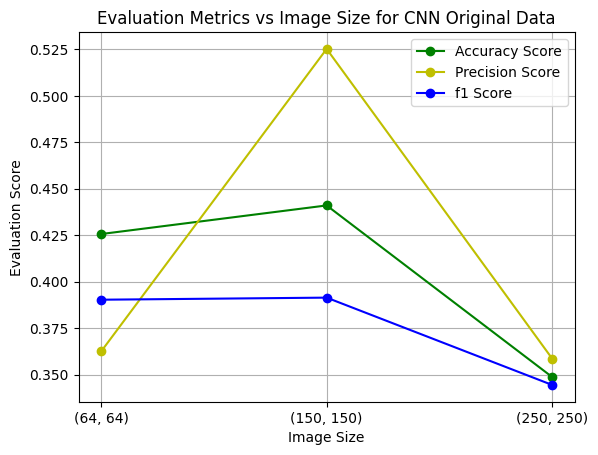

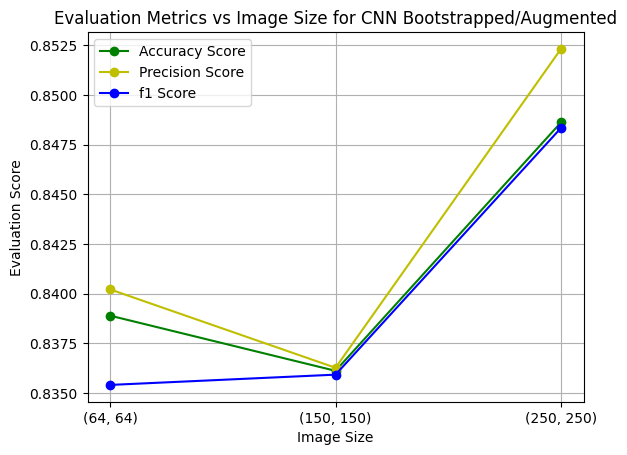

In [110]:
create_accuracy_rating_graph(file_conv_accuracy_results, 'CNN Original Data')
create_accuracy_rating_graph(files_augmented_conv_accuracy_results, 'CNN Bootstrapped/Augmented')

# ResNet Metrics

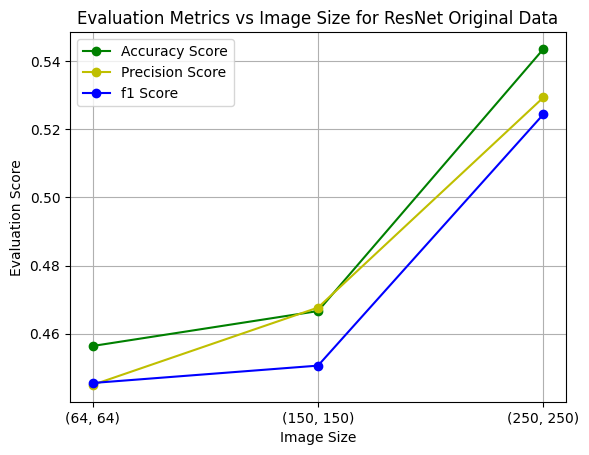

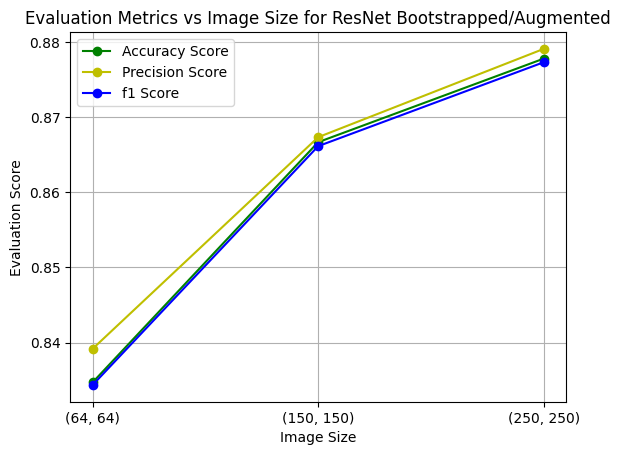

In [111]:
create_accuracy_rating_graph(file_resnet_accuracy_results, 'ResNet Original Data')
create_accuracy_rating_graph(files_augmented_resnet_accuracy_results, 'ResNet Bootstrapped/Augmented')

# MobileNet Metrics

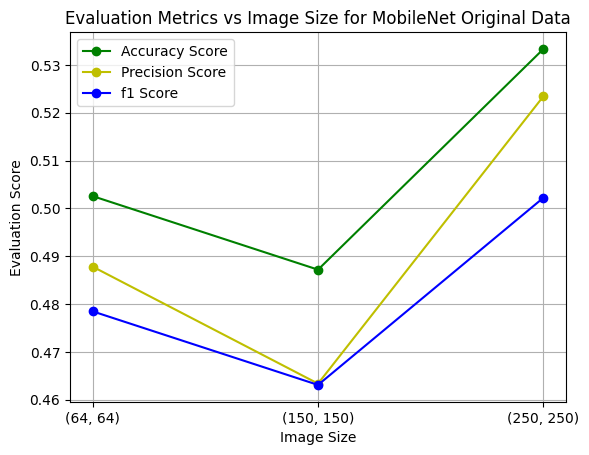

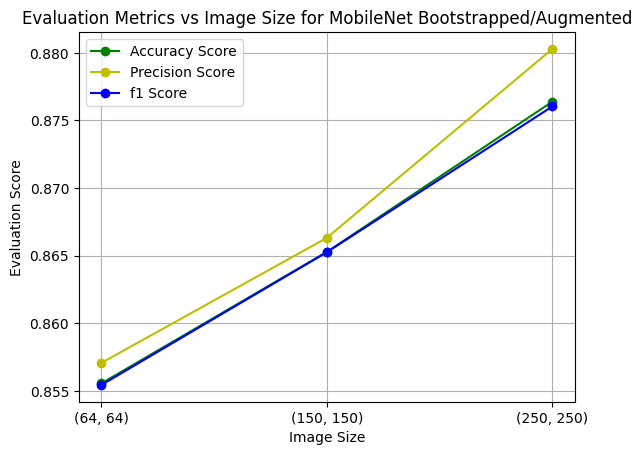

In [112]:
create_accuracy_rating_graph(file_mobilenet_accuracy_results, 'MobileNet Original Data')
create_accuracy_rating_graph(files_augmented_mobilenet_accuracy_results, 'MobileNet Bootstrapped/Augmented')

# DenseNet Metrics

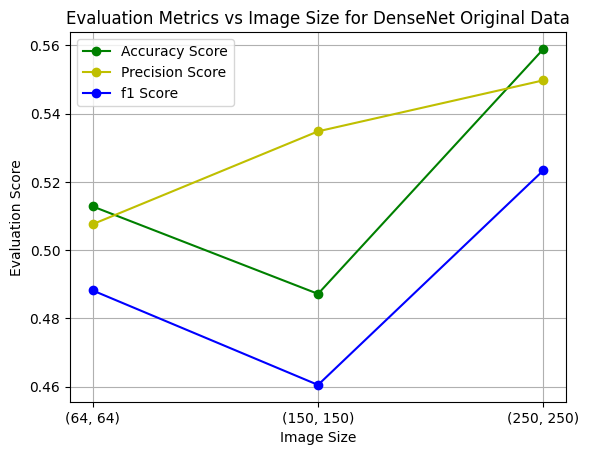

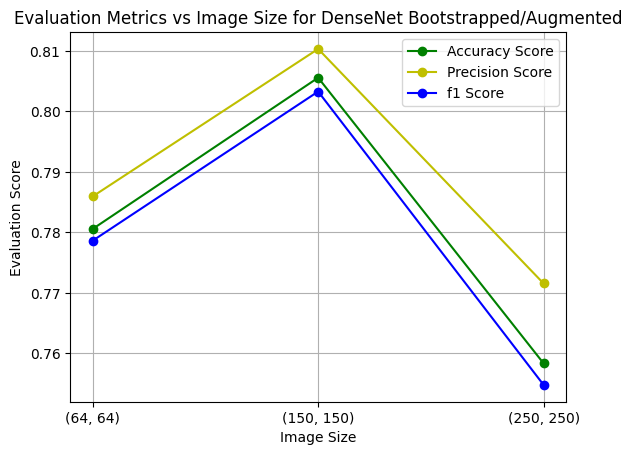

In [113]:
create_accuracy_rating_graph(file_densenet_accuracy_results, 'DenseNet Original Data')
create_accuracy_rating_graph(files_augmented_densenet_accuracy_results, 'DenseNet Bootstrapped/Augmented')